In [ ]:
! pip install "tensorflow>=2.0.0"
! pip install --upgrade tensorflow-hub

     |████████████████████████████████| 462 kB 5.3 MB/s 


In [ ]:
!python -m pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.5 MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import zipfile

zf = zipfile.ZipFile('/content/drive/MyDrive/BERT IMDB MOVIE REVIEW/archive.zip') 
df = pd.read_csv(zf.open('IMDB Dataset.csv'))

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  This show comes up with interesting locations ...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [ ]:
df['positive']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.sample(5)

,review,sentiment,positive
20094,LA ANTENA (Esteban Sapir - Argentina 2005).<br...,positive,1
12567,I love Henry James books and Washington Square...,negative,0
29371,Nurse Betty was definitely one of the most cre...,positive,1
49286,"Following a roughly 7 year rocky road on NBC, ...",positive,1
1402,ROAD TO PERDITION can be summed up by Thomas N...,positive,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],df['positive'], stratify = df['positive'])

In [ ]:
X_train.head(4)

12172    Basic structure of a story: Beginning, Middle,...
25013    Kurt Russell is at his best as the man who liv...
33426    this is just usual Indian garbage that gets tu...
17185    After watching Avalon (which was decent only b...
Name: review, dtype: object

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
len(X_train)

37500

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1172/1172 [==============================] - 840s 704ms/step - loss: 0.6086 - accuracy: 0.6722 - precision: 0.6739 - recall: 0.6674
Epoch 2/10
1172/1172 [==============================] - 822s 702ms/step - loss: 0.5501 - accuracy: 0.7246 - precision: 0.7292 - recall: 0.7145
Epoch 3/10
1172/1172 [==============================] - 823s 702ms/step - loss: 0.5319 - accuracy: 0.7388 - precision: 0.7432 - recall: 0.7297
Epoch 4/10
1172/1172 [==============================] - 832s 710ms/step - loss: 0.5220 - accuracy: 0.7423 - precision: 0.7474 - recall: 0.7321
Epoch 5/10
1172/1172 [==============================] - 831s 709ms/step - loss: 0.5154 - accuracy: 0.7482 - precision: 0.7536 - recall: 0.7375
Epoch 6/10
1172/1172 [==============================] - 828s 707ms/step - loss: 0.5117 - accuracy: 0.7477 - precision: 0.7538 - recall: 0.7356
Epoch 7/10
1172/1172 [==============================] - 823s 702ms/step - loss: 0.5111 - accuracy: 0.7497 - precision: 0.7553 - recall: 0.7387

In [ ]:
model.evaluate(X_test, y_test)

391/391 [==============================] - 277s 706ms/step - loss: 0.4749 - accuracy: 0.7792 - precision: 0.8010 - recall: 0.7430


[0.4748745560646057, 0.77920001745224, 0.8009658455848694, 0.7430400252342224]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import pickle
pickle.dump(model, open('bert_pickle.sav', 'wb')) 

INFO:tensorflow:Assets written to: ram://bca24bf3-3413-4772-a9cb-ebdc6cb690eb/assets


INFO:tensorflow:Assets written to: ram://bca24bf3-3413-4772-a9cb-ebdc6cb690eb/assets


In [ ]:
loaded_model = pickle.load(open('bert_pickle.sav', 'rb'))

In [ ]:
loaded_model.evaluate(X_test, y_test)

391/391 [==============================] - 280s 709ms/step - loss: 0.4749 - accuracy: 0.7792 - precision: 0.8010 - recall: 0.7430


[0.4748745560646057, 0.77920001745224, 0.8009658455848694, 0.7430400252342224]

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[5096, 1154],
       [1606, 4644]])

Text(33.0, 0.5, 'Truth')

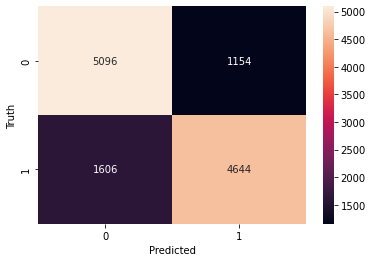

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      6250
           1       0.80      0.74      0.77      6250

    accuracy                           0.78     12500
   macro avg       0.78      0.78      0.78     12500
weighted avg       0.78      0.78      0.78     12500



In [ ]:
reviews = [
    "Kites” is not a traditional Indian movie, but rather a breath-taking action. This film is a romantic love story of an Indian guy Gee (Bollywood star Rithik Roshan) and a Mexican girl Natasha (Barbara Mori). They fell in love at first sight, despite the fact that she did not understand Hindi and speaks only Spanish, while he could speak only Hindi and English. Besides, Natasha was already engaged to another man. However, there are no barriers for true love."
    
]
model.predict(reviews)

array([[0.82633984]], dtype=float32)